> #### We try to learn the filter-back projection in a "denoising" way. For this, we implement a denoising autoencoder Neural Network architecture that learns the filter-back projection line by line.
> #### In other words, we then try to counter the blurring effect implied by a learned projection using a denoiser autoencoder.
> #### For each angle, we implement an autoencoder. Stacking these autoencoders together provides a general Neural Network architecture we call the SinoNet.
> #### Warning : to reproduce more precisely what happens with a true DBT, one must take in account that only a limited range of projections angle is possible to obtain.

> Schéma : 
<img src="talbonet.png",width=500, height=500>

# Packages Loading

In [118]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input
from keras.layers import Activation, UpSampling2D, BatchNormalization, Reshape
from keras.models import Sequential, Input, Model
from keras.utils.np_utils import to_categorical
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from keras import backend as K
from keras import optimizers
%matplotlib inline
import numpy as np
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

# Data Loading

### Projection matrix

In [3]:
import scipy.io
mat = scipy.io.loadmat('thinL64_90.mat')
A = mat['H'].todense()

### Training Data

In [52]:
import h5py
brains = []
N = int(0.8*767)
for i in range(1, N):
    with  h5py.File('brains-master/%s.mat' %i, 'r') as f:
        brain = np.array(f['cjdata']['image'])
        brain = brain[::8, ::8]
        brains += [brain]

brains = np.array(brains)
print(brains.shape)

(612, 64, 64)


### Projections Data

In [53]:
projections = []
for i in range(brains.shape[0]):
    p = np.matmul(A, brains[i].flatten())
    p = p.reshape((90,90))
    projections += [p]
    
projections = np.array(projections)
print(projections.shape)

(612, 90, 90)


### Vizualisations

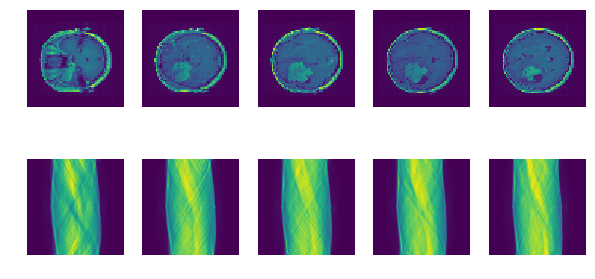

In [54]:
fig=plt.figure(figsize=(10, 5))

for i in range(5):
    idx = np.random.randint(766)
    fig.add_subplot(2, 5, i+1)
    plt.imshow(brains[i])
    plt.axis('off')
    fig.add_subplot(2, 5, i+6)
    plt.imshow(projections[i])
    plt.axis('off')

In [55]:
projections[0].shape

(90, 90)

In [56]:
alpha = 10 #a certain angle of projection (the real tomography for cancer uses a limited range of angle)
outputs = []
for i in range(brains.shape[0]):
    outputs.append(projections[i,:,alpha])
outputs = np.array(outputs)

In [57]:
outputs[0]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        34.12320043,  95.25596386, 141.88577048, 175.78454529,
       207.52938119, 245.05512159, 271.41737893, 280.85656656,
       294.40675062, 309.12749826, 323.6440572 , 338.46194178,
       351.56006373, 359.31255646, 367.93828265, 375.09984149,
       377.87533698, 376.95779014, 375.31428394, 373.56874271,
       373.37664441, 367.4279905 , 341.1262019 , 301.93512533,
       270.99392839, 245.65296789, 189.92981602, 101.90012818,
         8.15742029,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   3.79101735,  57.80631738,
       132.07963803, 186.62412216, 227.50846361, 272.02561262,
       317.38552127, 339.05411922, 331.47222316, 319.24025259,
       316.89732943, 316.09767113, 313.73616875, 311.20

# Decoupled Encoder-Decoder Training

In [58]:
X_train = brains
Y_train = outputs
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
Y_train = Y_train.reshape(Y_train.shape[0], 90, 1)

In [59]:
X_train = X_train/np.max(X_train)
Y_train = Y_train/np.max(Y_train)

In [60]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
model.add(Conv2D(16, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(90))
adam = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',optimizer=adam)
model.summary()
model.fit(X_train,Y_train,batch_size=32,epochs=100, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 16, 16, 64)        18496     
__________

766/766 [==============================] - 11s - loss: 0.1600    
Epoch 83/100
766/766 [==============================] - 10s - loss: 0.1636    
Epoch 84/100
766/766 [==============================] - 10s - loss: 0.1627    
Epoch 85/100
766/766 [==============================] - 10s - loss: 0.1600    
Epoch 86/100
766/766 [==============================] - 9s - loss: 0.1593     
Epoch 87/100
766/766 [==============================] - 9s - loss: 0.1590     
Epoch 88/100
766/766 [==============================] - 9s - loss: 0.1592     
Epoch 89/100
766/766 [==============================] - 9s - loss: 0.1590     
Epoch 90/100
766/766 [==============================] - 9s - loss: 0.1587     
Epoch 91/100
766/766 [==============================] - 10s - loss: 0.1585    
Epoch 92/100
766/766 [==============================] - 11s - loss: 0.1596    
Epoch 93/100
766/766 [==============================] - 10s - loss: 0.1596    
Epoch 94/100
766/766 [==============================] - 10s - los

In [89]:
X_train_decoder = outputs
Y_train_decoder = projections
X_train_decoder = X_train_decoder.reshape(X_train_decoder.shape[0], 90)
Y_train_decoder = Y_train_decoder.reshape(Y_train_decoder.shape[0], 90, 90, 1)
X_train_decoder = X_train_decoder/np.max(X_train_decoder)
Y_train_decoder = Y_train_decoder/np.max(Y_train_decoder)

In [121]:
model_decoder = Sequential()
model_decoder.add(Dense(25, input_shape = (90,)))
model_decoder.add(Reshape((5, 5, 1)))
model_decoder.add(UpSampling2D((3, 3)))
model_decoder.add(Conv2D(64, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
model_decoder.add(Conv2D(64, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model_decoder.add(UpSampling2D((2, 2)))
model_decoder.add(Conv2D(32, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
model_decoder.add(Conv2D(32, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model_decoder.add(UpSampling2D((3, 3)))
model_decoder.add(Conv2D(16, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
model_decoder.add(Conv2D(1, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
adam = optimizers.Adam(lr=0.001)
model_decoder.compile(loss='binary_crossentropy',optimizer=adam)
model_decoder.summary()
model_decoder.fit(X_train_decoder,Y_train_decoder,batch_size=32,epochs=100, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 25)                2275      
_________________________________________________________________
reshape_44 (Reshape)         (None, 5, 5, 1)           0         
_________________________________________________________________
up_sampling2d_110 (UpSamplin (None, 15, 15, 1)         0         
_________________________________________________________________
conv2d_287 (Conv2D)          (None, 15, 15, 64)        640       
_________________________________________________________________
conv2d_288 (Conv2D)          (None, 15, 15, 64)        36928     
_________________________________________________________________
up_sampling2d_111 (UpSamplin (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_289 (Conv2D)          (None, 30, 30, 32)        18464     
__________

612/612 [==============================] - 19s - loss: 0.3286    
Epoch 83/100
612/612 [==============================] - 20s - loss: 0.3287    
Epoch 84/100
612/612 [==============================] - 21s - loss: 0.3289    
Epoch 85/100
612/612 [==============================] - 22s - loss: 0.3283    
Epoch 86/100
612/612 [==============================] - 20s - loss: 0.3284    
Epoch 87/100
612/612 [==============================] - 20s - loss: 0.3292    
Epoch 88/100
612/612 [==============================] - 19s - loss: 0.3287    
Epoch 89/100
612/612 [==============================] - 19s - loss: 0.3289    
Epoch 90/100
612/612 [==============================] - 20s - loss: 0.3286    
Epoch 91/100
612/612 [==============================] - 20s - loss: 0.3283    
Epoch 92/100
612/612 [==============================] - 20s - loss: 0.3285    
Epoch 93/100
612/612 [==============================] - 20s - loss: 0.3285    
Epoch 94/100
612/612 [==============================] - 20s - los

# Coupled Encoder-Decoder Training